In [ ]:
#!pip install pyro-ppl
#!pip install arviz
#!pip install torchviz
#!pip install torch-summary

In [ ]:
import pyro
import torch
import pickle
import numpy as np
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from tqdm.auto import trange

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.datasets import load_breast_cancer

import torch.nn as nn
from torchviz import make_dot
from torchsummary import summary

import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import MCMC, NUTS
from pyro.infer import Predictive
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer.autoguide import AutoNormal

from scipy.stats import norm

In [ ]:
data = load_breast_cancer()

X = data.data
Y = data.target

print("Shape of features (X):", X.shape)
print("Shape of target (y):", Y.shape)

Shape of features (X): (569, 30)
Shape of target (y): (569,)


In [ ]:
X = scale(X)

In [ ]:
X_training, X_test, Y_training, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_training, Y_training, test_size=0.2, random_state=42)


X_train = torch.from_numpy(X_train.astype(np.float32))
Y_train = torch.from_numpy(Y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
Y_test = torch.from_numpy(Y_test.astype(np.float32))
X_val = torch.from_numpy(X_val.astype(np.float32))
Y_val = torch.from_numpy(Y_val.astype(np.float32))

In [ ]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

torch.Size([386, 30]) torch.Size([386]) torch.Size([86, 30]) torch.Size([86])


In [ ]:
class BNN(PyroModule):
    def __init__(self, in_dim=30, out_dim=1, hid_dim=15, prior_scale=1.):
        super().__init__()

        assert in_dim > 0 and out_dim > 0 and hid_dim > 0
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)
        self.layer2 = PyroModule[nn.Linear](hid_dim, hid_dim)
        self.layer3 = PyroModule[nn.Linear](hid_dim, hid_dim)
        self.layer4 = PyroModule[nn.Linear](hid_dim, out_dim)


        self.bn1 = nn.BatchNorm1d(hid_dim)
        self.bn2 = nn.BatchNorm1d(hid_dim)
        self.bn3 = nn.BatchNorm1d(hid_dim)
        self.bn4 = nn.BatchNorm1d(hid_dim)

        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer3.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, hid_dim]).to_event(2))
        self.layer3.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer4.weight = PyroSample(dist.Normal(0., prior_scale).expand([out_dim, hid_dim]).to_event(2))
        self.layer4.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim]).to_event(1))


    def forward(self, x, y=None):
        x = x.reshape(-1, 30)
        x = nn.functional.relu(self.layer1(x))
        x = self.bn1(x)
        x = nn.functional.relu(self.layer2(x))
        x = self.bn2(x)
        x = nn.functional.relu(self.layer3(x))
        x = self.bn3(x)

        mu = torch.sigmoid(self.layer4(x).squeeze())
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Bernoulli(probs=mu), obs=y)

        return mu

In [ ]:
model = BNN()
summary(model, input_size=(1, 30))

Layer (type:depth-idx)                   Param #
├─result: 1-1                            --
├─result: 1-2                            --
├─result: 1-3                            --
├─result: 1-4                            --
├─BatchNorm1d: 1-5                       30
├─BatchNorm1d: 1-6                       30
├─BatchNorm1d: 1-7                       30
├─BatchNorm1d: 1-8                       30
Total params: 120
Trainable params: 120
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─result: 1-1                            --
├─result: 1-2                            --
├─result: 1-3                            --
├─result: 1-4                            --
├─BatchNorm1d: 1-5                       30
├─BatchNorm1d: 1-6                       30
├─BatchNorm1d: 1-7                       30
├─BatchNorm1d: 1-8                       30
Total params: 120
Trainable params: 120
Non-trainable params: 0

dummy_input = torch.randn(2, 30)

graph = make_dot(model(X_train), params=dict(model.named_parameters()))

graph.render("model_architecture", format="png")

In [ ]:
pyro.clear_param_store()

model = BNN()

nuts_kernel = NUTS(model, target_accept_prob = 0.6)
mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=100, num_chains = 2)
mcmc.run(X_train, Y_train)

/usr/local/lib/python3.10/dist-packages/pyro/infer/mcmc/api.py:499: UserWarning: num_chains=2 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(
Sample [1]: 100%|██████████| 2100/2100 [1:04:47,  1.85s/it, step size=1.95e-02, acc. prob=0.811]


In [ ]:
print(mcmc.summary())


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
      layer1.bias[0]      0.11      1.02      0.10     -1.53      1.75   3441.76      1.00
      layer1.bias[1]      0.11      1.02      0.11     -1.45      1.86   4178.04      1.00
      layer1.bias[2]      0.10      1.03      0.12     -1.66      1.77   3959.74      1.00
      layer1.bias[3]      0.12      0.98      0.12     -1.55      1.67   2820.29      1.00
      layer1.bias[4]      0.10      0.99      0.09     -1.52      1.72   3916.81      1.00
      layer1.bias[5]      0.12      1.02      0.13     -1.49      1.84   3582.04      1.00
      layer1.bias[6]      0.09      1.03      0.12     -1.55      1.82   3977.41      1.00
      layer1.bias[7]      0.12      0.99      0.13     -1.41      1.83   3921.40      1.00
      layer1.bias[8]      0.11      1.00      0.11     -1.59      1.74   3263.04      1.00
      layer1.bias[9]      0.09      1.00      0.11     -1.57      1.73   3062.58      1.0

/usr/local/lib/python3.10/dist-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'layer1.bias'}>,
        <Axes: title={'center': 'layer1.bias'}>],
       [<Axes: title={'center': 'layer1.weight'}>,
        <Axes: title={'center': 'layer1.weight'}>],
       [<Axes: title={'center': 'layer2.bias'}>,
        <Axes: title={'center': 'layer2.bias'}>],
       [<Axes: title={'center': 'layer2.weight'}>,
        <Axes: title={'center': 'layer2.weight'}>],
       [<Axes: title={'center': 'layer3.bias'}>,
        <Axes: title={'center': 'layer3.bias'}>],
       [<Axes: title={'center': 'layer3.weight'}>,
        <Axes: title={'center': 'layer3.weight'}>],
       [<Axes: title={'center': 'layer4.bias'}>,
        <Axes: title={'center': 'layer4.bias'}>],
       [<Axes: title={'center': 'layer4.weight'}>,
        <Axes: title={'center': 'layer4.weight'}>]], dtype=object)

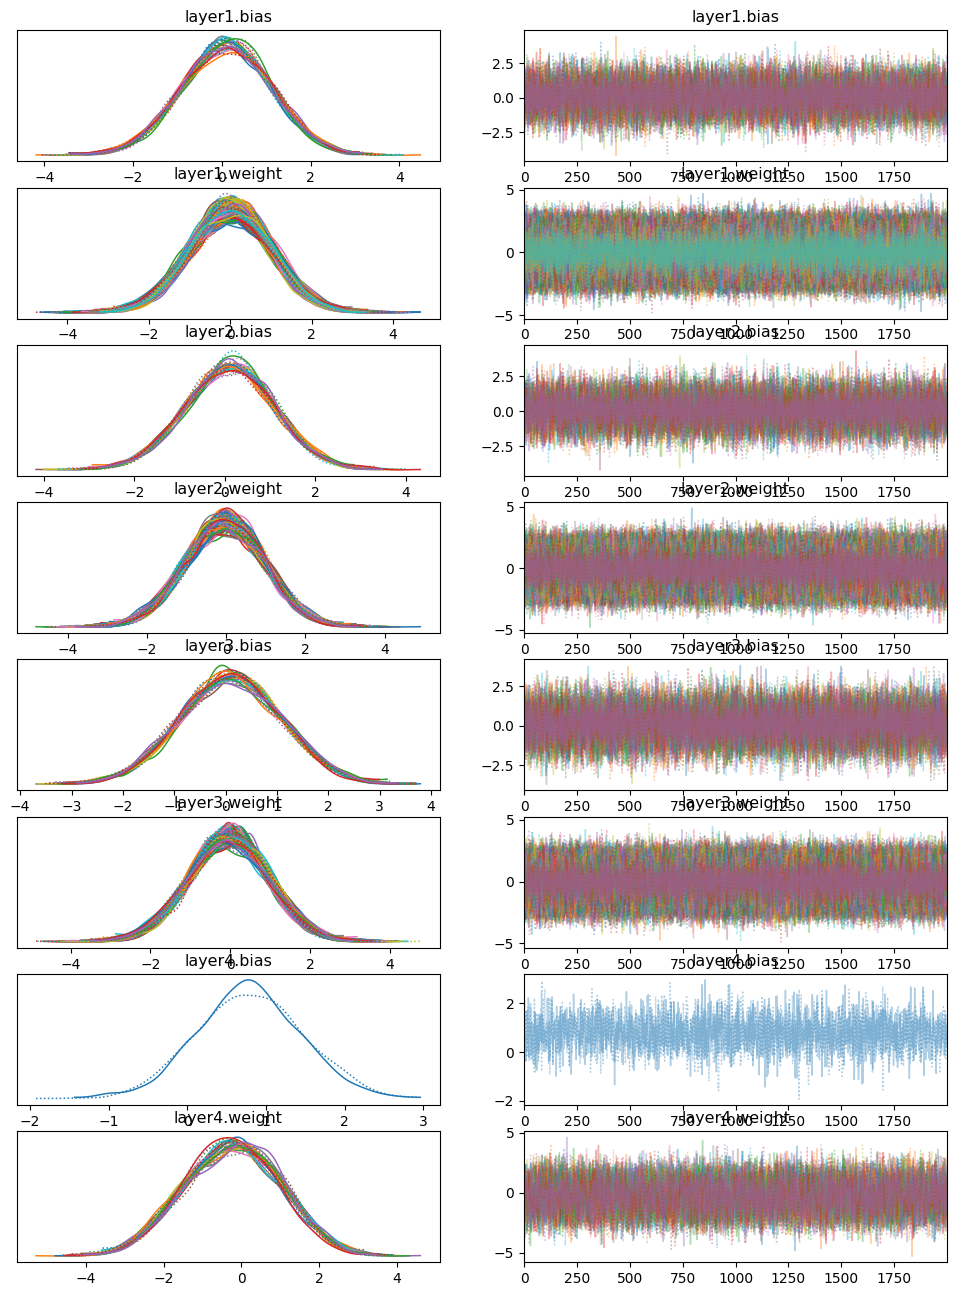

In [ ]:
posterior = az.from_pyro(mcmc)
az.plot_trace(posterior)

In [ ]:
predictive1 = Predictive(model=model, posterior_samples=mcmc.get_samples())
preds1 = predictive1(X_test)
print(preds1)
preds1_list = preds1['obs'].tolist()
Y_test_list = Y_test.tolist()

{'obs': tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])}


In [ ]:
average_accuracy = sum(accuracy_score(Y_test_list, prediction) for prediction in preds1_list) / len(preds1_list)
average_f1 = sum(f1_score(Y_test_list, prediction) for prediction in preds1_list) / len(preds1_list)

print(f"Average accuracy: {average_accuracy}")
print(f"Average f1 score: {average_f1}")

Average accuracy: 0.9307238372092763
Average f1 score: 0.9445852263745443


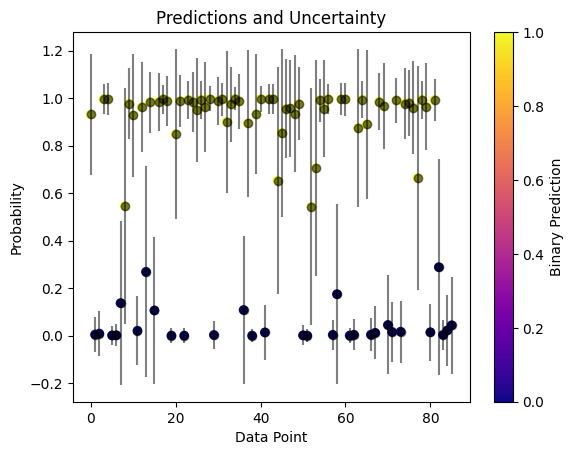

In [ ]:
pred1_probs = preds1['obs'].detach().numpy()

mean_pred1 = np.mean(pred1_probs, axis=0)
std_pred1 = np.std(pred1_probs, axis=0)

binary_pred = np.where(mean_pred1 > 0.5, 1, 0)

plt.scatter(np.arange(len(Y_test)), mean_pred1, c=binary_pred, cmap='plasma')
plt.errorbar(np.arange(len(Y_test)), mean_pred1, yerr=std_pred1, fmt='o', color='black', alpha=0.5)
plt.colorbar(label='Binary Prediction')
plt.xlabel('Data Point')
plt.ylabel('Probability')
plt.title('Predictions and Uncertainty')
plt.show()

In [ ]:
pyro.clear_param_store()

model = BNN()
mean_field_guide = AutoNormal(model)
#mean_field_guide = AutoNormal(model)
#optimizer = pyro.optim.RMSprop({"lr": 0.0005})
optimizer = pyro.optim.AdamW({"lr": 0.005})
svi = SVI(model, mean_field_guide, optimizer, loss=Trace_ELBO())

elbo_values = []

test_losses = []

num_epochs = 20000

progress_bar = trange(num_epochs)

for epoch in progress_bar:
    loss = svi.step(X_train, Y_train)
    elbo_values.append(loss / X_train.shape[0])

    with torch.no_grad():
        test_loss = svi.evaluate_loss(X_val, Y_val)
        test_losses.append(test_loss / X_val.shape[0])

    progress_bar.set_postfix(loss=f"{loss / X_train.shape[0]:.3f}", test_loss=f"{test_loss / X_val.shape[0]:.3f}")



  0%|          | 0/20000 [00:00<?, ?it/s]

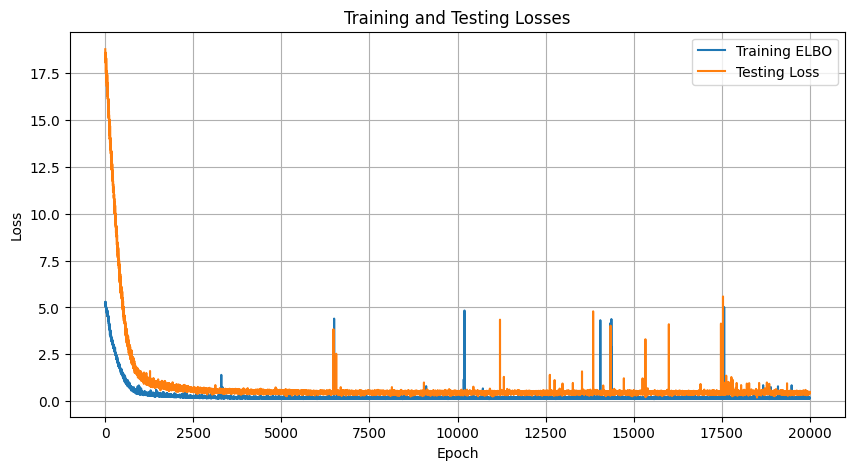

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), elbo_values, label='Training ELBO')
plt.plot(range(1, num_epochs + 1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(min(elbo_values))

0.10602903505063428


In [ ]:
predictive2 = Predictive(model=model, guide=mean_field_guide, num_samples=10000)
preds2 = predictive2(X_test)
preds2_list = preds2['obs'].tolist()
Y_test_list = Y_test.tolist()

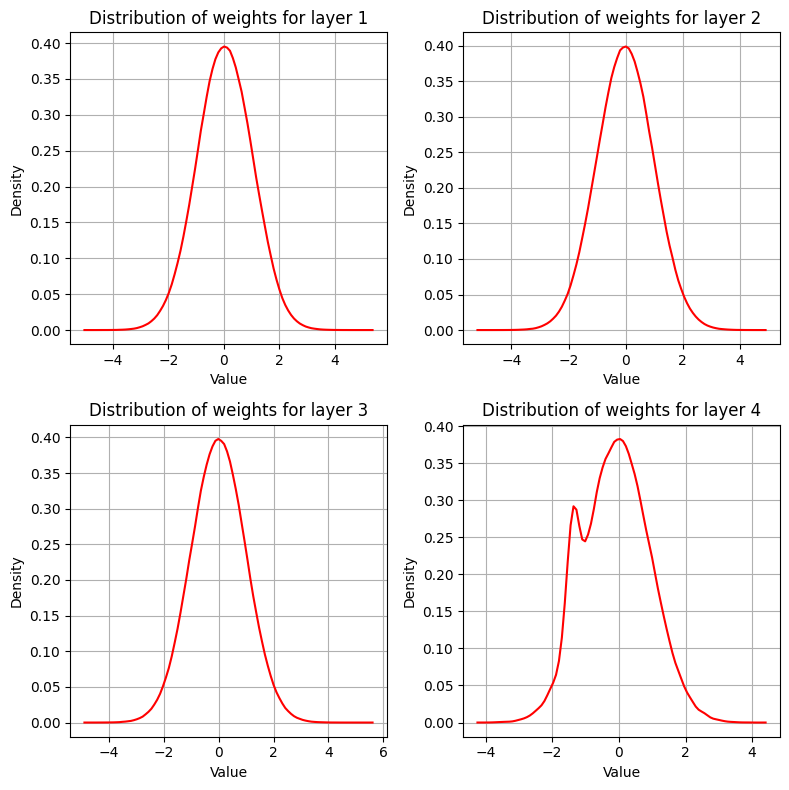

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
weight_tensors = [value for key, value in preds2.items() if 'weight' in key]
for i, weight_tensor in enumerate(weight_tensors):
    flattened_values = weight_tensor.flatten().numpy()

    row = i // 2
    col = i % 2

    axs[row, col].set_title(f'Distribution of weights for layer {i+1}')
    axs[row, col].set_xlabel('Value')
    axs[row, col].set_ylabel('Density')

    from scipy.stats import gaussian_kde
    kde = gaussian_kde(flattened_values)
    x_values = np.linspace(min(flattened_values), max(flattened_values), 100)
    axs[row, col].plot(x_values, kde(x_values), 'r', label='KDE')
    axs[row, col].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
average_accuracy = sum(accuracy_score(Y_test_list, prediction) for prediction in preds2_list) / len(preds2_list)
average_f1 = sum(f1_score(Y_test_list, prediction) for prediction in preds2_list) / len(preds2_list)

print(f"Average accuracy: {average_accuracy}")
print(f"Average f1 score: {average_f1}")

Average accuracy: 0.9578918604650837
Average f1 score: 0.9663608356648019


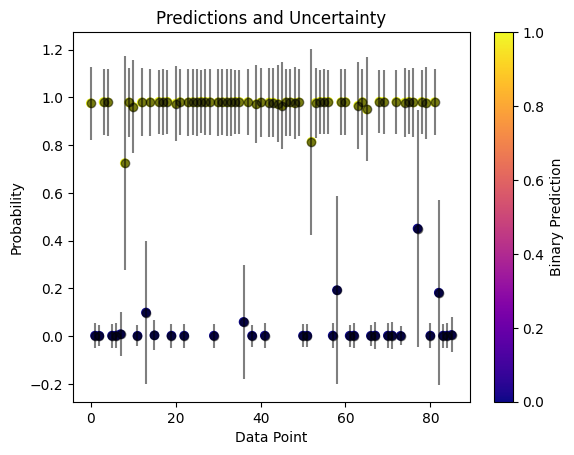

In [ ]:
pred2_probs = preds2['obs'].detach().numpy()
mean_pred2 = np.mean(pred2_probs, axis=0)
std_pred2 = np.std(pred2_probs, axis=0)

binary_pred = np.where(mean_pred2 > 0.5, 1, 0)

plt.scatter(np.arange(len(Y_test)), mean_pred2, c=binary_pred, cmap='plasma')
plt.errorbar(np.arange(len(Y_test)), mean_pred2, yerr=std_pred2, fmt='o', color='black', alpha=0.5)
plt.colorbar(label='Binary Prediction')
plt.xlabel('Data Point')
plt.ylabel('Probability')
plt.title('Predictions and Uncertainty')
plt.show()

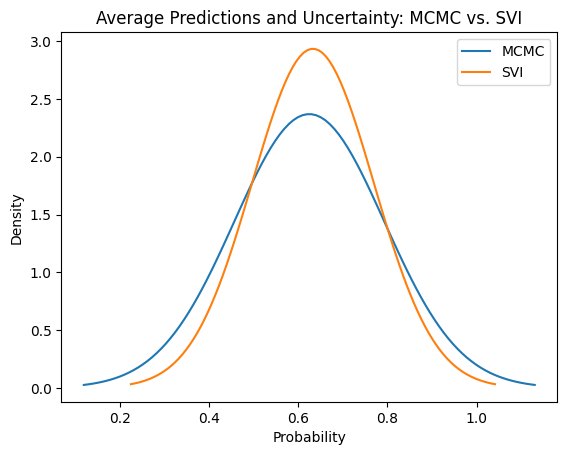

In [ ]:
mean_pred1_all = np.mean(mean_pred1)
std_pred1_all = np.mean(std_pred1)

mean_pred2_all = np.mean(mean_pred2)
std_pred2_all = np.mean(std_pred2)

x_values_svi = np.linspace(mean_pred1_all - 3 * std_pred1_all, mean_pred1_all + 3 * std_pred1_all, 100)
plt.plot(x_values_svi, norm.pdf(x_values_svi, mean_pred1_all, std_pred1_all), label='MCMC')

x_values_mcmc = np.linspace(mean_pred2_all - 3 * std_pred2_all, mean_pred2_all + 3 * std_pred2_all, 100)
plt.plot(x_values_mcmc, norm.pdf(x_values_mcmc, mean_pred2_all, std_pred2_all), label='SVI')

plt.xlabel('Probability')
plt.ylabel('Density')
plt.title('Average Predictions and Uncertainty: MCMC vs. SVI')
plt.legend()
plt.show()
